In [149]:
from bmi_topography import Topography
# import packages 
import os
import warnings

import numpy as np
import pandas as pd
import xarray
from datetime import datetime
import cftime
import matplotlib.pyplot as plt
from matplotlib import colors
import imageio.v2 as imageio
from IPython.display import Video
from tqdm import trange

from pymt.models import Topography
from landlab import RasterModelGrid, imshow_grid, imshow_grid_at_node
from landlab.components import FlowAccumulator, ChannelProfiler
from landlab.components.overland_flow import OverlandFlow
from landlab.plot.drainage_plot import drainage_plot
from landlab.utils import get_watershed_mask

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'font.size': 14})

In [150]:
# topo = Topography(
#     dem_type="SRTMGL3",
#     south=36.166667,
#     north=36.333333,
#     west=-121.916667,
#     east=-121.583333,
#     output_format="GTiff",
#     cache_dir=".",
# )

In [151]:
config_dir = "config_dir"
dem = Topography()
# dem.initialize(os.path.join(config_dir, 'dem.yaml'))
dem.initialize('dem.yaml')


/opt/miniconda3/envs/landlab/lib/python3.13/site-packages/bmi_topography/api_key.py:48: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.csdms.io/en/latest/#api-key for more information.
  warnings.warn(


In [152]:
# get DEM variable info
var_name = dem.output_var_names[0]
var_unit = dem.var_units(var_name)
var_location = dem.var_location(var_name)
var_type = dem.var_type(var_name)
var_grid = dem.var_grid(var_name)
var_itemsize = dem.var_itemsize(var_name)
var_nbytes = dem.var_nbytes(var_name)
print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
            '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: land_surface__elevation 
var_unit: degrees 
var_location: face 
var_type: int16 
var_grid: 0 
var_itemsize: 2
var_nbytes: 25831260 



In [153]:
# get DEM grid info 
dem_grid_ndim = dem.grid_ndim(var_grid) 
dem_grid_type = dem.grid_type(var_grid)
dem_grid_shape = dem.grid_shape(var_grid)
dem_grid_spacing = dem.grid_spacing(var_grid)
dem_grid_origin = dem.grid_origin(var_grid)

print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
    dem_grid_ndim, dem_grid_type, dem_grid_shape, dem_grid_spacing, dem_grid_origin))

grid_ndim: 2 
grid_type: uniform_rectilinear 
grid_shape: [2905 4446] 
grid_spacing: [0.00027778 0.00027778] 
grid_origin: [  42.60805556 -124.63694444]


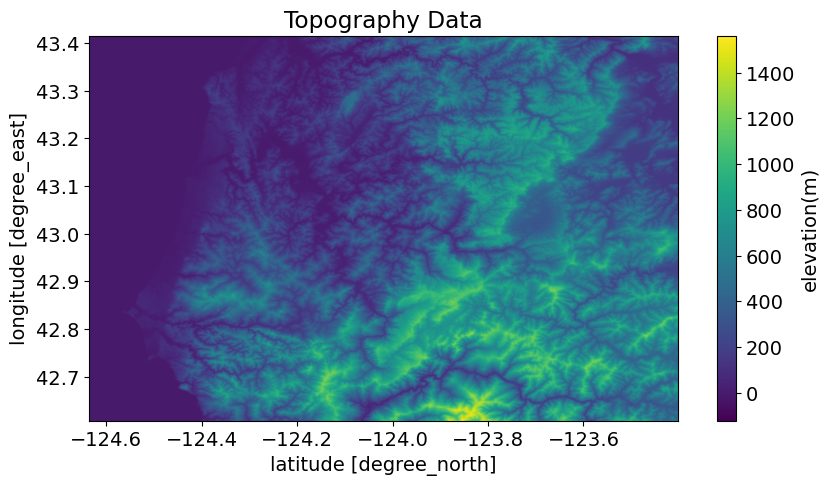

In [154]:
# get DEM variable data
dem_data = dem.get_value(var_name)
dem_data_2D = dem_data.reshape(dem_grid_shape)

# get X, Y extent for plot
min_y, min_x = dem_grid_origin
max_y = min_y + dem_grid_spacing[0]*(dem_grid_shape[0]-1)
max_x = min_x + dem_grid_spacing[1]*(dem_grid_shape[1]-1)
dy = dem_grid_spacing[0]/2
dx = dem_grid_spacing[1]/2
dem_extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

# plot DEM data
fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(dem_data_2D, extent=dem_extent)
ax.title.set_text('Topography Data')
ax.set_xlabel('latitude [degree_north]')
ax.set_ylabel('longitude [degree_east]')
fig.colorbar(im,label='elevation(m)')

Text(0, 0.5, 'north-south distance (m)')

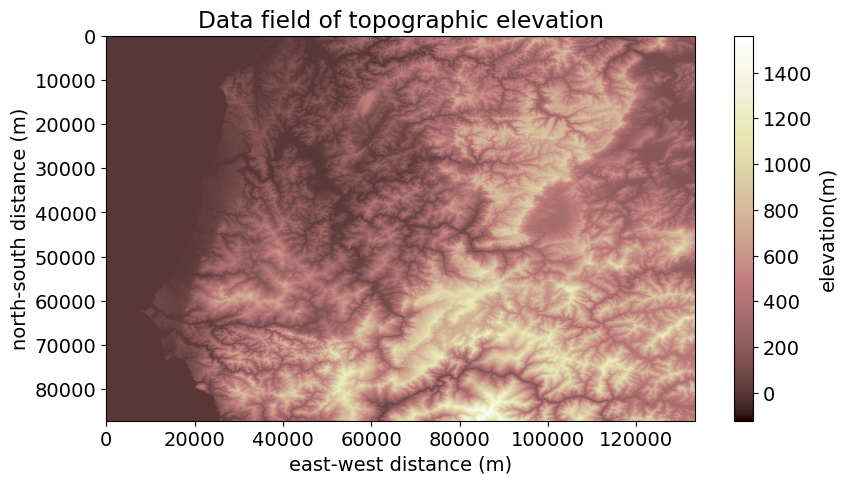

In [155]:
# set up raster model grid  
model_grid = RasterModelGrid(dem_grid_shape, xy_spacing=30)

# add topographic elevation data field
dem_field = model_grid.add_field("topographic__elevation", dem_data.astype('float'))

# plot the topographic elevation data field
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.invert_yaxis()
imshow_grid(model_grid,
            'topographic__elevation',
            plot_name='Data field of topographic elevation',
            var_name='elevation(m)')
ax.set_xlabel('east-west distance (m)')
ax.set_ylabel('north-south distance (m)')


In [156]:
# calculate the flow accumulation
fa=FlowAccumulator( model_grid, method='Steepest', 
                    flow_director='FlowDirectorSteepest', 
                    depression_finder='LakeMapperBarnes',
                    redirect_flow_steepest_descent=True,
                    reaccumulate_flow=True)
fa.run_one_step()

Text(0, 0.5, 'north-south distance (m)')

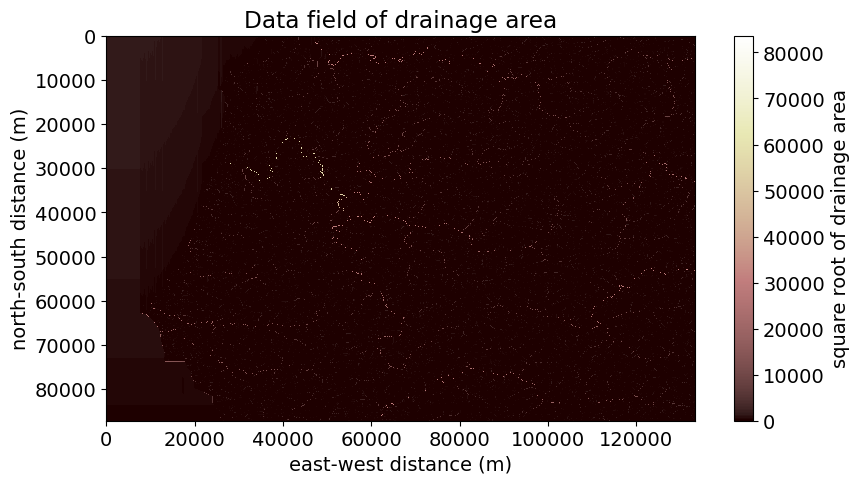

In [157]:
# plot the flow accumulation result
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.invert_yaxis()
imshow_grid(
    model_grid,
    np.sqrt(model_grid.at_node["drainage_area"]),
    plot_name="Data field of drainage area",
    var_name="square root of drainage area",
)
ax.set_xlabel('east-west distance (m)')
ax.set_ylabel('north-south distance (m)')

In [158]:
# set up channel profiler 
profiler = ChannelProfiler(model_grid,number_of_watersheds=1)
profiler.run_one_step()

In [ ]:
# get watershed mask
outlet = profiler.nodes[0][0]
print(outlet)
# watershed_mask = get_watershed_mask(model_grid, outlet)

1


In [160]:
import geopandas as gpd

<Axes: >

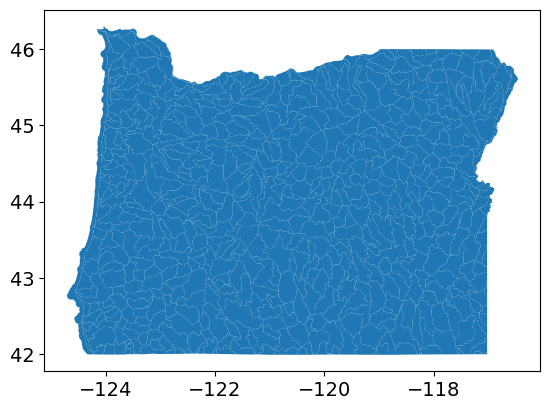

In [161]:
# Replace with your file path
gdf = gpd.read_file("Oregon_Watersheds%3A_10_Digit_Hydrologic_Units_(2024).geojson")

# View the first few rows
# print(gdf.head())

# Plot the geometries (optional)
gdf.plot()

In [162]:
# List of names you want to combine
names_to_combine = ['North Fork Coquille River', 'Middle Fork Coquille River',
                    'South Fork Coquille River', 'East Fork Coquille River',
                    'Coquille River']

# Filter rows where 'name' is in your list
subset = gdf[gdf['name'].isin(names_to_combine)]

<Axes: >

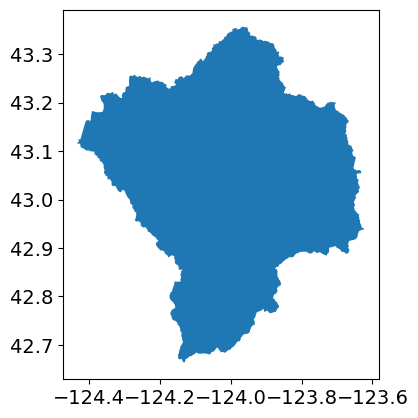

In [163]:
# Combine geometries into one using unary_union
from shapely.ops import unary_union
combined_geom = unary_union(subset.geometry)

# Optional: create a new GeoDataFrame with the result
combined_gdf = gpd.GeoDataFrame(geometry=[combined_geom], crs=gdf.crs)

# View or save
combined_gdf.plot()

In [ ]:
import numpy as np
import rasterio.features
import geopandas as gpd

# dem_data_2D is your actual DEM array
topo = dem_data_2D

# Assume x and y define the grid spacing (must be evenly spaced!)
x = np.linspace(min_x, max_x, topo.shape[1])
y = np.linspace(max_y, min_y, topo.shape[0])  # top to bottom

# Create affine transform (assumes regular grid)
from affine import Affine
res_x = (x[-1] - x[0]) / (len(x) - 1)
res_y = (y[0] - y[-1]) / (len(y) - 1)  # descending y
transform = Affine.translation(x[0] - res_x / 2, y[0] - res_y / 2) * Affine.scale(res_x, -res_y)

# Rasterize the polygon to create a mask
mask = rasterio.features.rasterize(
    [(combined_gdf.geometry.iloc[0], 1)],  # shapes = [(geometry, value)]
    out_shape=topo.shape,
    transform=transform,
    fill=0,
    dtype='uint8'
).astype(bool)

# Apply mask to your DEM
topo_masked = np.where(mask, model_grid, -9999.0)


: 

In [146]:
model_grid.at_node["watershed"] = model_grid.at_node["topographic__elevation"].copy()

In [147]:
# set watershed boundary
# watershed = model_grid.copy()
model_grid.at_node["watershed"][~watershed_mask] = -9999.0
model_grid.status_at_node[~watershed_mask] = model_grid.BC_NODE_IS_CLOSED
model_grid.status_at_node[outlet] = model_grid.BC_NODE_IS_FIXED_VALUE

Text(0, 0.5, 'north-south distance (m)')

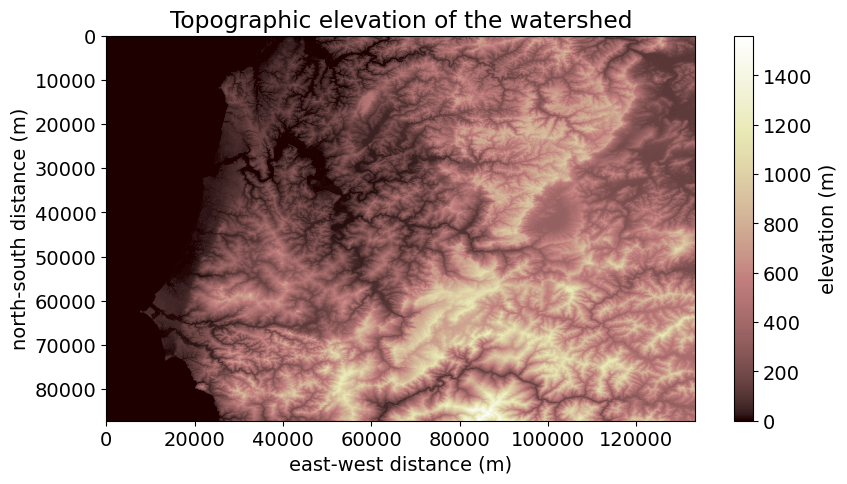

In [168]:
# plot the watershed 
plt.figure(figsize=(10,5))
ax = plt.gca()
ax.invert_yaxis()
imshow_grid_at_node(model_grid, model_grid.at_node["topographic__elevation"], 
                    plot_name='Topographic elevation of the watershed',
                    colorbar_label="elevation (m)")

ax.set_xlabel('east-west distance (m)')
ax.set_ylabel('north-south distance (m)')

In [121]:
watershed_mask

array([False,  True, False, ..., False, False, False])

In [122]:
# bins = np.arange(0, 1500, 25)
edges_eq   = np.linspace(0, dem_field.max(), 25)
hist_eq, _ = np.histogram(dem_field, bins=edges_eq)


In [123]:
hist_eq

array([3134537,  932779,  910301,  880171,  831947,  856846,  809133,
        761032,  700815,  683294,  640732,  549114,  406184,  288443,
        206139,  144546,   93170,   44640,   16238,    9062,    7085,
          5617,    3208,     597])

In [124]:
area = np.sum(hist_eq)
area

12915630

In [125]:
hist_eq_proportion=hist_eq/area*100
hist_eq_proportion

array([2.42693310e+01, 7.22209447e+00, 7.04805728e+00, 6.81477404e+00,
       6.44139697e+00, 6.63417890e+00, 6.26475828e+00, 5.89233355e+00,
       5.42610000e+00, 5.29044267e+00, 4.96090396e+00, 4.25154638e+00,
       3.14490273e+00, 2.23328634e+00, 1.59604293e+00, 1.11915563e+00,
       7.21374025e-01, 3.45627739e-01, 1.25723639e-01, 7.01630505e-02,
       5.48560155e-02, 4.34899420e-02, 2.48381225e-02, 4.62230646e-03])

In [126]:
check = np.sum(hist_eq_proportion)
check

100.0

In [127]:
watershed_mask = np.where(
    model_grid.at_node['topographic__elevation'] > 0,
    1,
    0
)
area = model_grid.cell_area_at_node * watershed_mask
total=np.sum(area / 1e6)

In [128]:
total

9727.184699999956

In [129]:
bins_elevation_sqkm = hist_eq_proportion * 1e-2 * total
bins_elevation_sqkm

array([2.36072266e+03, 7.02506468e+02, 6.85577549e+02, 6.62885658e+02,
       6.26566581e+02, 6.45318835e+02, 6.09384609e+02, 5.73158168e+02,
       5.27806769e+02, 5.14611129e+02, 4.82556291e+02, 4.13555769e+02,
       3.05910497e+02, 2.17235887e+02, 1.55250044e+02, 1.08862335e+02,
       7.01693838e+01, 3.36198486e+01, 1.22293706e+01, 6.82488951e+00,
       5.33594595e+00, 4.23034699e+00, 2.41605005e+00, 4.49620287e-01])

In [84]:
A = bins_elevation_sqkm.astype(float)

In [85]:
np.savetxt('hydro_bins.txt', A)

In [86]:
np.sum(bins_elevation_sqkm)

9727.184699999956

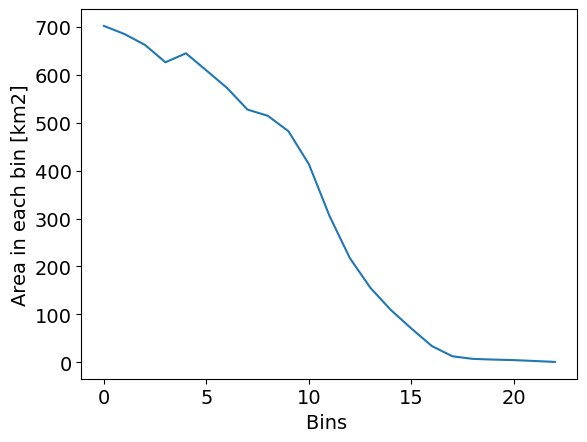

In [87]:

plt.plot(bins_elevation_sqkm[1:])
plt.xlabel("Bins ")      # ← x‑axis label
plt.ylabel("Area in each bin [km2]")
plt.show()